In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [2]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from artifact import Saw
from detector import WindowTransformerDetector

from data import RealisticArtifactDataset, CachedArtifactDataset, TestArtifactDataset

/opt/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)

In [4]:
test_width = 512
test_file = Path(f"../data/test_{test_width}.pkl")
test_datasets = [
    "australian_electricity_demand_dataset", # accuracy  ~0.95
    "electricity_hourly_dataset", # accuracy ~0.976
    "electricity_load_diagrams", # ~0.953
    "HouseholdPowerConsumption1",
    "HouseholdPowerConsumption2",
    "london_smart_meters_dataset_without_missing_values",
    "solar_10_minutes_dataset",
    "wind_farms_minutely_dataset_without_missing_values",
]

In [5]:
def load_series(names: list[str], split: str):
    series = list()
    counts = list()
    for name in names:
        with open(f"../data/processed/{name}_{split}.pickle", "rb") as f:
            raw = [a for a in pickle.load(f) if len(a) > test_width]
            series.extend(np.array(a).astype(np.float32) for a in raw)
            counts.extend(repeat(1 / len(raw), len(raw)))
    counts = np.array(counts)
    return series, counts / counts.sum()

In [6]:
# validation
if not test_file.exists():
    val_data, val_weights = load_series(test_datasets, "VAL")
    val_gen = RealisticArtifactDataset(val_data,
                              width=test_width,
                              padding=64,
                              artifact=Saw(),
                              weight=val_weights)
    val = CachedArtifactDataset.generate(val_gen,
                                         n=2048,
                                         to=test_file)
else:
    val = CachedArtifactDataset(file=test_file)

In [7]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

#autheticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config(
    credential=credential,
    path="config.json",
)

Found the config file in: config.json


In [8]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

first_detector = WindowTransformerDetector.load_from_checkpoint("../models/model.ckpt").cpu()

data_asset = ml_client.data.get("output_Train_GPU_full_train", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_detector = WindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=50000.ckpt").cpu()

data_asset = ml_client.data.get("output_Train_GPU_full_simple_train", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_conv/", datastore_operation=ml_client.datastores)
convolution_detector = WindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_conv/Checkpoint-model_name=0-validation=0.03.ckpt").cpu()


/opt/miniconda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.8, which is newer than your current Lightning version: v2.0.0
  rank_zero_warn(


In [9]:
def baseline_detector(input: torch.Tensor) -> torch.Tensor:
    input.squeeze(0)

    prediction = torch.zeros(input.shape)
    # flag points with very high increment as artifact
    # Calculate increments by subtracting the tensor shifted by one from the original tensor
    increments = (input[1:] - input[:-1]).abs()
    mean_increment = torch.mean(increments)
    std_increment = torch.std(increments)
    mask = increments > mean_increment + 3*std_increment
    shaped_mask = torch.cat((mask, torch.Tensor([False]))).type(torch.bool)
    prediction[shaped_mask] = 1
    
    # flag highest/lowest point as artifact
    # or better also with mean/std?
    absolute_values = input.abs()
    max_index = torch.argmax(absolute_values)
    prediction[max_index-5 : max_index+5] = 1


    return prediction

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import pandas as pd

metrics = pd.DataFrame(columns=['detector', 'accuracy', 'precision', 'recall', 'mse'])
index = 0

preds_base = list()
preds_cnn = list()
preds_trans = list()
gt = list()

threshold = 0.5

for sample in val:
    example = sample["data"]
    stride  = 64
    window  = convolution_detector.window
    length  = len(example)

    # add artifact to data
    example_data = torch.tensor(example + sample["artifact"])

    # store prediction for each window
    predictions_baseline = torch.zeros(((length - window) // stride + 1, length))
    predictions_conv = torch.zeros(((length - window) // stride + 1, length))
    predictions_trans = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted
    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
        # make prediction and insert into prediction
        predictions_baseline[i, j : j + window] = baseline_detector(s)
        predictions_conv[i, j : j + window] = convolution_detector(s.unsqueeze(0))
        predictions_trans[i, j : j + window] = transformer_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    predictions_baseline = predictions_baseline.sum(axis=0) / masks
    preds_base = preds_base + predictions_baseline.tolist()
    predictions_baseline = np.where(predictions_baseline.numpy() > threshold, 1, 0)
    predictions_conv = predictions_conv.sum(axis=0) / masks
    preds_cnn = preds_cnn + predictions_conv.tolist()
    predictions_conv = np.where(predictions_conv.numpy() > threshold, 1, 0)
    predictions_trans = predictions_trans.sum(axis=0) / masks
    preds_trans = preds_trans + predictions_trans.tolist()
    predictions_trans = np.where(predictions_trans.numpy() > threshold, 1, 0)
    gt = gt + sample["mask"].tolist()

    tn_base, fp_base, fn_base, tp_base = confusion_matrix(sample["mask"], predictions_baseline, labels=[0, 1]).ravel()
    tn_conv, fp_conv, fn_conv, tp_conv = confusion_matrix(sample["mask"], predictions_conv, labels=[0, 1]).ravel()
    tn_trans, fp_trans, fn_trans, tp_trans = confusion_matrix(sample["mask"], predictions_trans, labels=[0, 1]).ravel()

    new_row_baseline = pd.DataFrame([{
        'index': index,
        'detector': 'baseline',
        'accuracy': accuracy_score(sample["mask"], predictions_baseline),
        'precision': precision_score(sample["mask"], predictions_baseline),
        'recall': recall_score(sample["mask"], predictions_baseline),
        'mse': mean_squared_error(sample["mask"], predictions_baseline), 
        'tn': tn_base,
        'fp': fp_base, 
        'fn': fn_base, 
        'tp': tp_base
    }])

    new_row_conv = pd.DataFrame([{
        'index': index,
        'detector': 'cnn',
        'accuracy': accuracy_score(sample["mask"], predictions_conv),
        'precision': precision_score(sample["mask"], predictions_conv),
        'recall': recall_score(sample["mask"], predictions_conv),
        'mse': mean_squared_error(sample["mask"], predictions_conv),
        'tn': tn_conv,
        'fp': fp_conv, 
        'fn': fn_conv, 
        'tp': tp_conv
    }])

    new_row_trans = pd.DataFrame([{
        'index': index,
        'detector': 'transformer',
        'accuracy': accuracy_score(sample["mask"], predictions_trans),
        'precision': precision_score(sample["mask"], predictions_trans),
        'recall': recall_score(sample["mask"], predictions_trans),
        'mse': mean_squared_error(sample["mask"], predictions_trans),
        'tn': tn_trans,
        'fp': fp_trans, 
        'fn': fn_trans, 
        'tp': tp_trans
    }])

    metrics = pd.concat([metrics, new_row_baseline, new_row_conv, new_row_trans], ignore_index=True)
    index = index+1


/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precis

In [12]:
metrics_total = metrics.groupby('detector')[['accuracy', 'precision', 'recall', 'mse']].mean()
conf_mat_values = metrics.groupby('detector')[['tn', 'fp', 'fn', 'tp']].sum()

In [13]:
metrics_total

,accuracy,precision,recall,mse
detector,,,,
baseline,0.953847,0.273267,0.206362,0.046153
cnn,0.981388,0.468121,0.363496,0.018612
transformer,0.989667,0.691251,0.593675,0.010333


In [14]:
conf_mat_values = conf_mat_values.convert_dtypes()
conf_mat_values

,tn,fp,fn,tp
detector,,,,
baseline,1988294,46787,50002,12069
cnn,2029143,5938,33094,28977
transformer,2032506,2575,19094,42977


In [18]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(gt, preds_base)
J = precision + recall
ix = np.argmax(J)
best_thresh_base = thresholds[ix]

precision, recall, thresholds = precision_recall_curve(gt, preds_cnn)
J = precision + recall
ix = np.argmax(J)
best_thresh_cnn = thresholds[ix]

precision, recall, thresholds = precision_recall_curve(gt, preds_trans)
J = precision + recall
ix = np.argmax(J)
best_thresh_trans = thresholds[ix]


In [11]:
from sklearn.metrics import fbeta_score

max_fbeta = 0
best_threshold = 0

for threshold in np.linspace(0,  1,  100):
    predictions_trans = np.where(preds_trans > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_trans, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold = threshold


In [24]:
best_threshold

0.48484848484848486

In [13]:
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve")

NameError: name 'recall' is not defined

In [ ]:
predictions_baseline = np.where(preds_base > best_thresh_base, 1, 0)
predictions_conv = np.where(preds_cnn > best_thresh_cnn, 1, 0)
predictions_trans = np.where(preds_trans > best_thresh_trans, 1, 0)

tn_base, fp_base, fn_base, tp_base = confusion_matrix(gt, predictions_baseline, labels=[0, 1]).ravel()
tn_conv, fp_conv, fn_conv, tp_conv = confusion_matrix(gt, predictions_conv, labels=[0, 1]).ravel()
tn_trans, fp_trans, fn_trans, tp_trans = confusion_matrix(gt, predictions_trans, labels=[0, 1]).ravel()

metrics = pd.DataFrame([{
    'detector': 'baseline',
    'threshold': best_thresh_base,
    'accuracy': accuracy_score(gt, predictions_baseline),
    'precision': precision_score(gt, predictions_baseline),
    'recall': recall_score(gt, predictions_baseline),
    'mse': mean_squared_error(gt, predictions_baseline), 
    'tn': tn_base,
    'fp': fp_base, 
    'fn': fn_base, 
    'tp': tp_base
}, 
{
    'detector': 'cnn',
    'threshold': best_thresh_cnn,
    'accuracy': accuracy_score(gt, predictions_conv),
    'precision': precision_score(gt, predictions_conv),
    'recall': recall_score(gt, predictions_conv),
    'mse': mean_squared_error(gt, predictions_conv), 
    'tn': tn_conv,
    'fp': fp_conv, 
    'fn': fn_conv, 
    'tp': tp_conv
}, 
{
    'detector': 'transformer',
    'threshold': best_thresh_trans,
    'accuracy': accuracy_score(gt, predictions_trans),
    'precision': precision_score(gt, predictions_trans),
    'recall': recall_score(gt, predictions_trans),
    'mse': mean_squared_error(gt, predictions_trans), 
    'tn': tn_trans,
    'fp': fp_trans, 
    'fn': fn_trans, 
    'tp': tp_trans
}]
)

In [48]:
freq_artifact = sum(gt)/(len(gt))
freq_artifact

0.029597759246826172

In [30]:
metrics

,detector,threshold,accuracy,precision,recall,mse,tn,fp,fn,tp
0,baseline,0.000000,0.939046,0.149178,0.225242,0.060954,1955342,79739,48090,13981
1,cnn,0.483376,0.981451,0.819768,0.478500,0.018549,2028551,6530,32370,29701
2,transformer,0.417684,0.990107,0.915131,0.733789,0.009893,2030857,4224,16524,45547


In [28]:
metrics

,detector,threshold,accuracy,precision,recall,mse,tn,fp,fn,tp
0,baseline,0.000000,0.939046,0.149178,0.225242,0.060954,1955342,79739,48090,13981
1,cnn,0.483376,0.981451,0.819768,0.478500,0.018549,2028551,6530,32370,29701
2,transformer,0.484848,0.989837,0.938993,0.702244,0.010163,2032249,2832,18482,43589


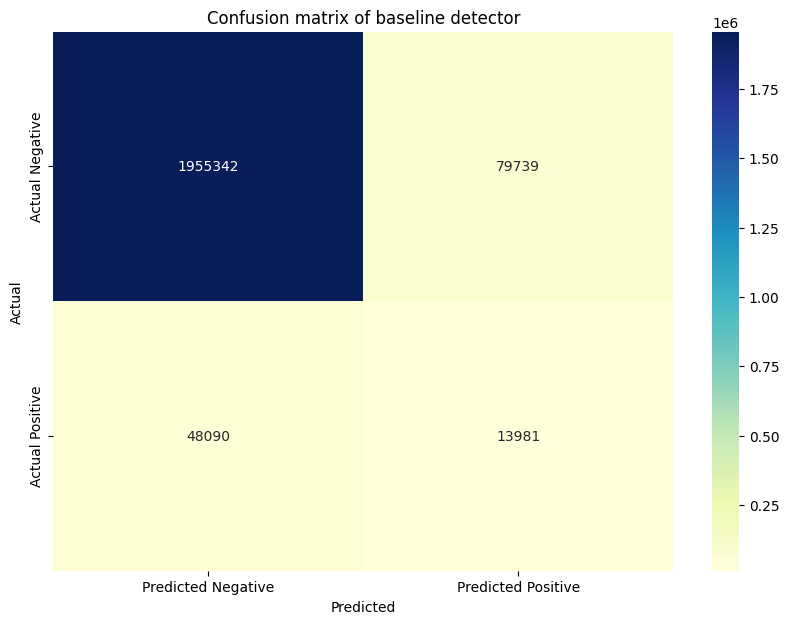

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

detector = 'baseline' # 'baseline', 'cnn', 'transformer'

# Construct the confusion matrix
cm = np.array([[metrics.loc[metrics.detector == detector, 'tn'].iloc[0], metrics.loc[metrics.detector == detector, 'fp'].iloc[0]],
               [metrics.loc[metrics.detector == detector, 'fn'].iloc[0], metrics.loc[metrics.detector == detector, 'tp'].iloc[0]]])
# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu",  xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative','Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion matrix of {detector} detector")
plt.show()

In [51]:
metrics

,detector,threshold,accuracy,precision,recall,mse,tn,fp,fn,tp
0,baseline,0.000000,0.939046,0.149178,0.225242,0.060954,1955342,79739,48090,13981
1,cnn,0.494328,0.981414,0.826846,0.470590,0.018586,2028964,6117,32861,29210
2,transformer,0.408680,0.990140,0.911486,0.738590,0.009860,2030629,4452,16226,45845


Text(0.5, 1.0, 'Validation ROC curve')

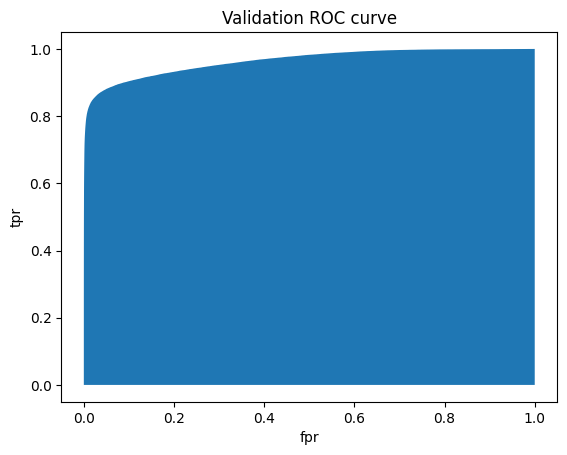

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(gt, preds_base)
J = tpr - fpr
ix = np.argmax(J)
best_thresh_baseline = thresholds[ix]

fpr, tpr, thresholds = roc_curve(gt, preds_cnn)
J = tpr - fpr
ix = np.argmax(J)
best_thresh_cnn = thresholds[ix]

fpr, tpr, thresholds = roc_curve(gt, preds_trans)
J = tpr - fpr
ix = np.argmax(J)
best_thresh_trans = thresholds[ix]

plt.fill_between(fpr, tpr)
plt.ylabel("tpr")
plt.xlabel("fpr")
plt.title("Validation ROC curve")

In [36]:
type(best_thresh_base)

In [37]:
predictions_baseline = np.where(preds_base > best_thresh_baseline, 1, 0)
predictions_conv = np.where(preds_cnn > best_thresh_cnn, 1, 0)
predictions_trans = np.where(preds_trans > best_thresh_trans, 1, 0)

tn_base, fp_base, fn_base, tp_base = confusion_matrix(gt, predictions_baseline, labels=[0, 1]).ravel()
tn_conv, fp_conv, fn_conv, tp_conv = confusion_matrix(gt, predictions_conv, labels=[0, 1]).ravel()
tn_trans, fp_trans, fn_trans, tp_trans = confusion_matrix(gt, predictions_trans, labels=[0, 1]).ravel()

metrics = pd.DataFrame([{
    'detector': 'baseline',
    'threshold': best_thresh_baseline,
    'accuracy': accuracy_score(gt, predictions_baseline),
    'precision': precision_score(gt, predictions_baseline),
    'recall': recall_score(gt, predictions_baseline),
    'mse': mean_squared_error(gt, predictions_baseline), 
    'tn': tn_base,
    'fp': fp_base, 
    'fn': fn_base, 
    'tp': tp_base
}, 
{
    'detector': 'cnn',
    'threshold': best_thresh_cnn,
    'accuracy': accuracy_score(gt, predictions_conv),
    'precision': precision_score(gt, predictions_conv),
    'recall': recall_score(gt, predictions_conv),
    'mse': mean_squared_error(gt, predictions_conv), 
    'tn': tn_conv,
    'fp': fp_conv, 
    'fn': fn_conv, 
    'tp': tp_conv
}, 
{
    'detector': 'transformer',
    'threshold': best_thresh_trans,
    'accuracy': accuracy_score(gt, predictions_trans),
    'precision': precision_score(gt, predictions_trans),
    'recall': recall_score(gt, predictions_trans),
    'mse': mean_squared_error(gt, predictions_trans), 
    'tn': tn_trans,
    'fp': fp_trans, 
    'fn': fn_trans, 
    'tp': tp_trans
}]
)

TypeError: '>' not supported between instances of 'list' and 'float'

In [56]:
metrics

,detector,threshold,accuracy,precision,recall,mse,tn,fp,fn,tp
0,baseline,0.125000,0.940758,0.152553,0.219877,0.059242,1959265,75816,48423,13648
1,cnn,0.061995,0.938876,0.291925,0.747193,0.061124,1922587,112494,15692,46379
2,transformer,0.085095,0.963981,0.444360,0.866298,0.036019,1967843,67238,8299,53772


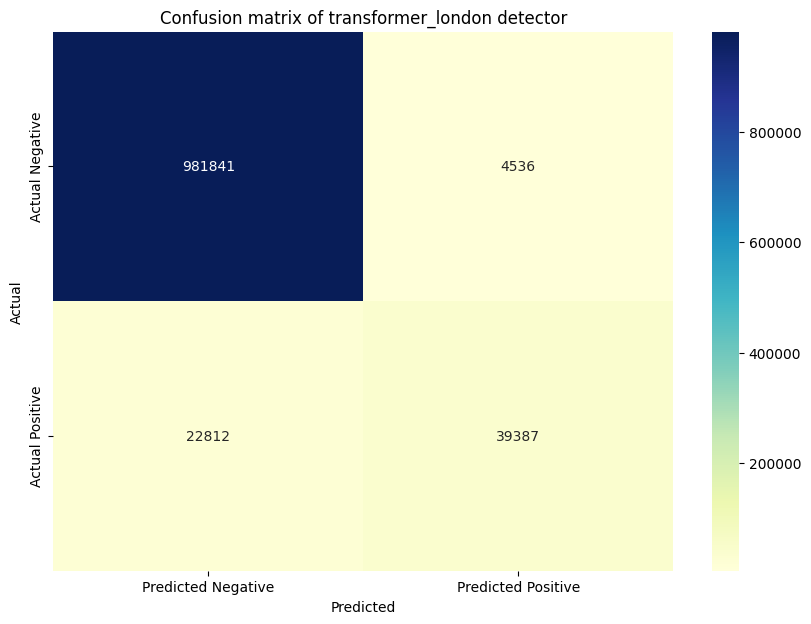

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

detector = 'transformer' # 'baseline', 'cnn', 'transformer'

# Construct the confusion matrix
cm = np.array([[conf_mat_values.loc[conf_mat_values.index == detector, 'tn'].iloc[0], conf_mat_values.loc[conf_mat_values.index == detector, 'fp'].iloc[0]],
               [conf_mat_values.loc[conf_mat_values.index == detector, 'fn'].iloc[0], conf_mat_values.loc[conf_mat_values.index == detector, 'tp'].iloc[0]]])
# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu",  xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative','Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion matrix of {detector} detector")
plt.show()

In [12]:
for i in range(2048):
    metrics_by_sample = metrics.groupby('index')[['tn', 'fp', 'fn', 'tp']].sum()

In [93]:
best_indices = metrics_by_sample.sort_values(by=['fp', 'fn'], ascending=True).index[:3]
middle_indices = metrics_by_sample.sort_values(by=['fp', 'fn'], ascending=True).index[1023:1026]
worst_indices = metrics_by_sample.sort_values(by=['fp', 'fn'], ascending=True).index[-3:]

In [15]:
metrics_transformer = metrics.query("detector == 'transformer'")

In [17]:
metrics_transformer.sort_values(by=["tp"], ascending=False).head(10)

,detector,accuracy,precision,recall,mse,index,tn,fp,fn,tp
5543,transformer,0.998047,0.983333,1.000000,0.001953,1847.0,452.0,1.0,0.0,59.0
3464,transformer,0.998047,1.000000,0.983051,0.001953,1154.0,453.0,0.0,1.0,58.0
1910,transformer,0.992188,0.935484,1.000000,0.007812,636.0,450.0,4.0,0.0,58.0
3962,transformer,1.000000,1.000000,1.000000,0.000000,1320.0,454.0,0.0,0.0,58.0
2480,transformer,0.996094,0.966667,1.000000,0.003906,826.0,452.0,2.0,0.0,58.0
494,transformer,0.996094,0.966667,1.000000,0.003906,164.0,452.0,2.0,0.0,58.0
2759,transformer,0.998047,1.000000,0.983051,0.001953,919.0,453.0,0.0,1.0,58.0
101,transformer,1.000000,1.000000,1.000000,0.000000,33.0,454.0,0.0,0.0,58.0
2213,transformer,0.998047,1.000000,0.983051,0.001953,737.0,453.0,0.0,1.0,58.0
254,transformer,1.000000,1.000000,1.000000,0.000000,84.0,454.0,0.0,0.0,58.0


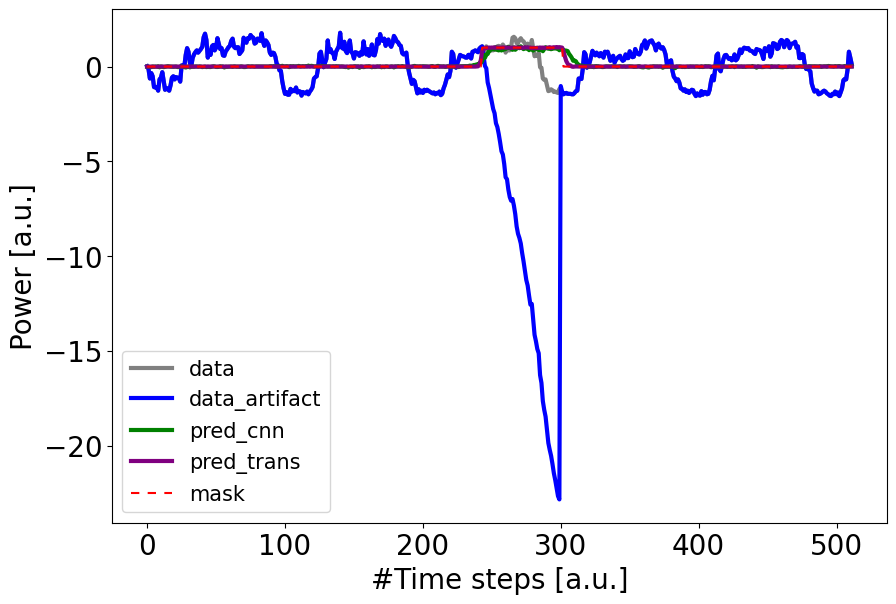

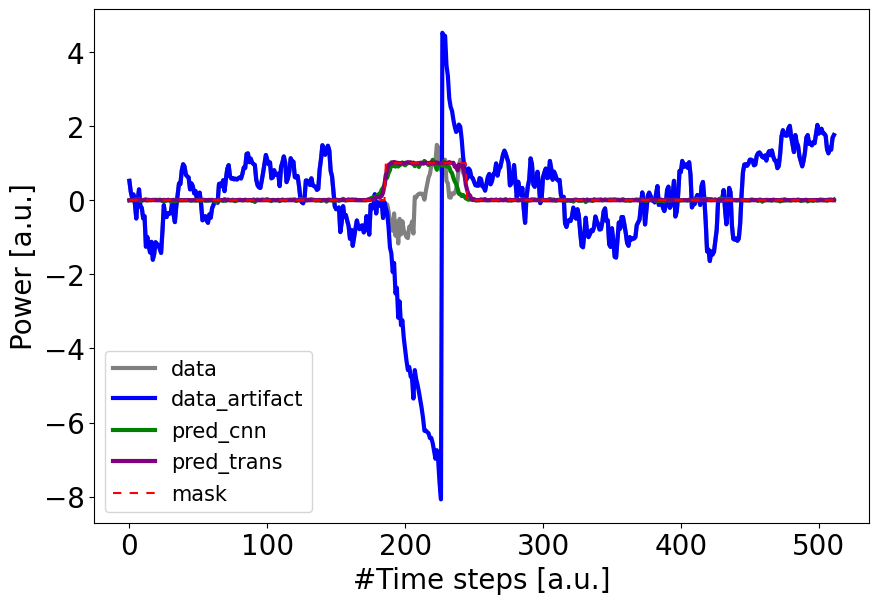

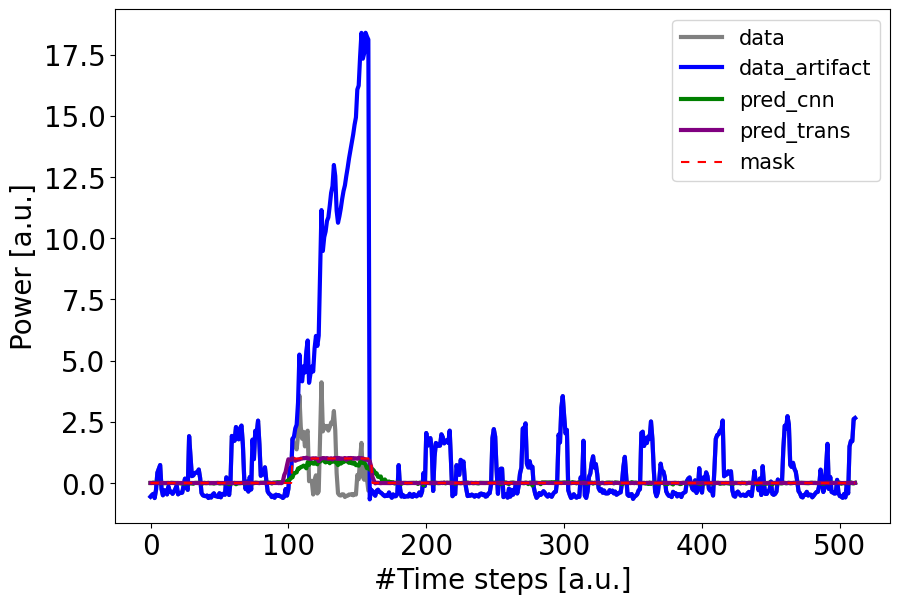

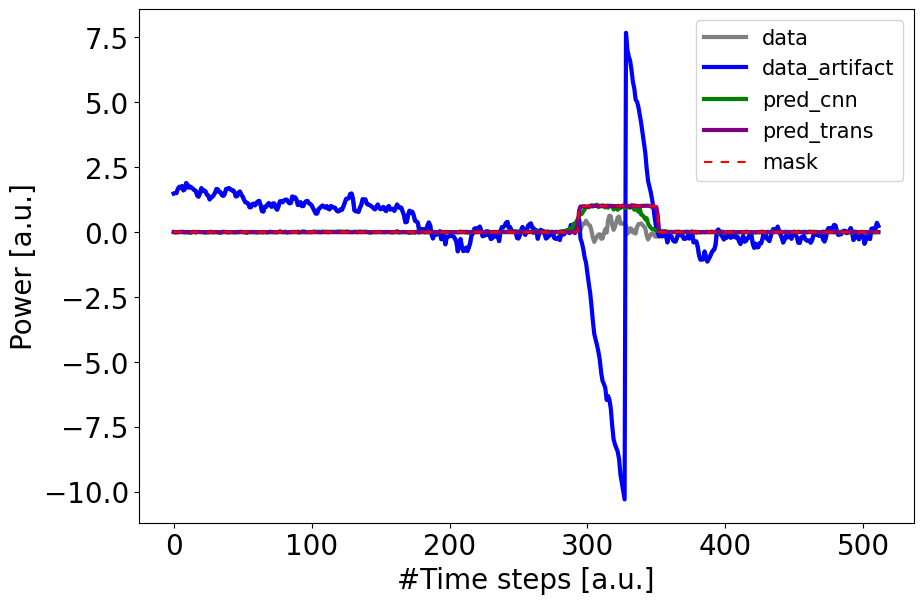

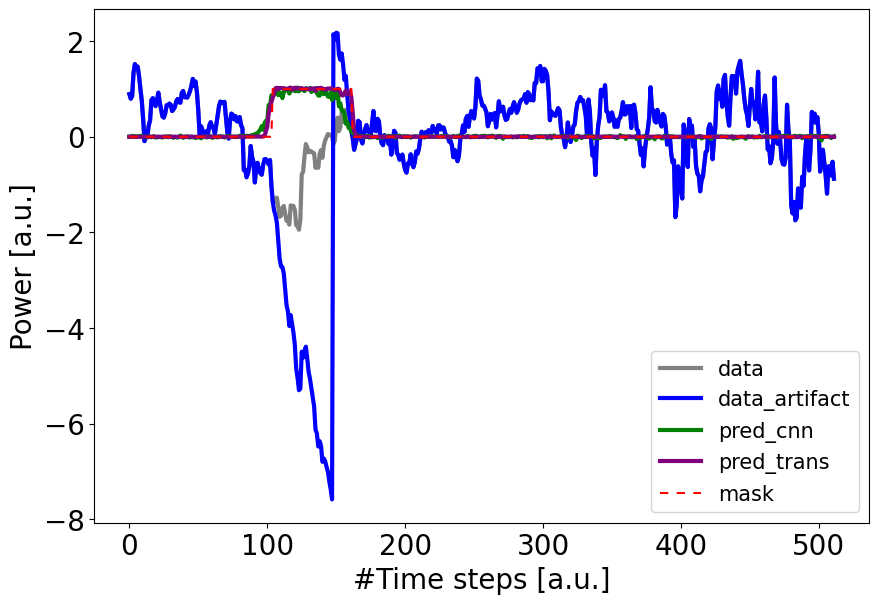

In [15]:
import matplotlib

best_indices_tp = [1847, 1154, 636, 1320, 826]
best_indices_fp = [507, 585, 1300, 868, 26]
best_indices_fn = [1178, 725, 1554, 520, 1679] # checken

threshold = 0.408

for index in best_indices_tp:
    sample = val[int(index)]
    example = sample["data"]
    stride  = 64
    window  = convolution_detector.window
    length  = len(example)

    # add artifact to data
    example_data = torch.tensor(example + sample["artifact"])

    # store prediction for each window
    predictions_baseline = torch.zeros(((length - window) // stride + 1, length))
    predictions_conv = torch.zeros(((length - window) // stride + 1, length))
    predictions_trans = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted
    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
        # make prediction and insert into prediction
        predictions_baseline[i, j : j + window] = baseline_detector(s)
        predictions_conv[i, j : j + window] = convolution_detector(s.unsqueeze(0))
        predictions_trans[i, j : j + window] = transformer_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    predictions_baseline = predictions_baseline.sum(axis=0) / masks
    # predictions_baseline = np.where(predictions_baseline.numpy() > threshold, 1, 0)
    predictions_conv = predictions_conv.sum(axis=0) / masks
    # predictions_conv = np.where(predictions_conv.numpy() > threshold, 1, 0)
    predictions_trans = predictions_trans.sum(axis=0) / masks
    # predictions_trans = np.where(predictions_trans.numpy() > threshold, 1, 0)

    plt.figure(figsize=(10, 6.666))
    plt.plot(sample["data"], label="data", c="grey", linewidth=3.0, zorder=0)
    plt.plot(example_data, label="data_artifact", c="blue", linewidth=3.0, zorder=1)
    # plt.plot(predictions_baseline, label="pred_baseline", c="orange")
    plt.plot(predictions_conv, label="pred_cnn", c="green", linewidth=3.0, zorder=2)
    plt.plot(predictions_trans, label="pred_trans", c="purple", linewidth=3.0, zorder=3)
    plt.plot(sample["mask"], c="red", label="mask", linewidth=1.5, linestyle='--', dashes=(4,4), zorder=4)

    # changing the fontsize of yticks
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel("#Time steps [a.u.]", fontsize=20)
    plt.ylabel("Power [a.u.]", fontsize=20)
    # to set the font size of the legend 
    matplotlib.rcParams['legend.fontsize'] = 15
    # plt.title(f"Predictions of transformer and CNN models vs. ground truth")
    plt.legend(loc='best')
    plt.show()

In [45]:
stats = Path(f"../data/stats_benchmark.pkl")
stats_ds = TestArtifactDataset(file=stats)

stats_indices = [1417, 629, 1794, 932, 2000, 507, 585, 1300, 868, 26, 1178, 725, 1554, 520, 1679]

stats_benchmark = [val[index] for index in stats_indices]


In [48]:
stats_benchmark = stats_ds + stats_benchmark
len(stats_benchmark)

30

In [ ]:
pickle.dump(stats_benchmark, open('../data/stats_benchmark.pkl', "wb"))

total accuracy of transformer model 0.9896998405456543

mean mse 0.009628971

In [27]:
example = val[3]
stride  = 64
window  = detector.window
length  = len(example["data"])

# add artifact to data
example_data = torch.tensor(example["data"] + example["artifact"])

# store prediction for each window
predictions = torch.zeros(((length - window) // stride + 1, length))

# store number of times each mask was predicted

masks = torch.zeros(length)
for i, j in enumerate(range(0, length - window + 1, stride)):
    # slice out window
    s = example_data[j : j + window]
    # make prediction and insert into prediction
    # predictions[i, j : j + window] = detector(s.unsqueeze(0))
    predictions[i, j : j + window] = baseline_detector(s)

    # update count
    masks[j : j + window] += 1

In [28]:
predictions = predictions.sum(axis=0) / masks


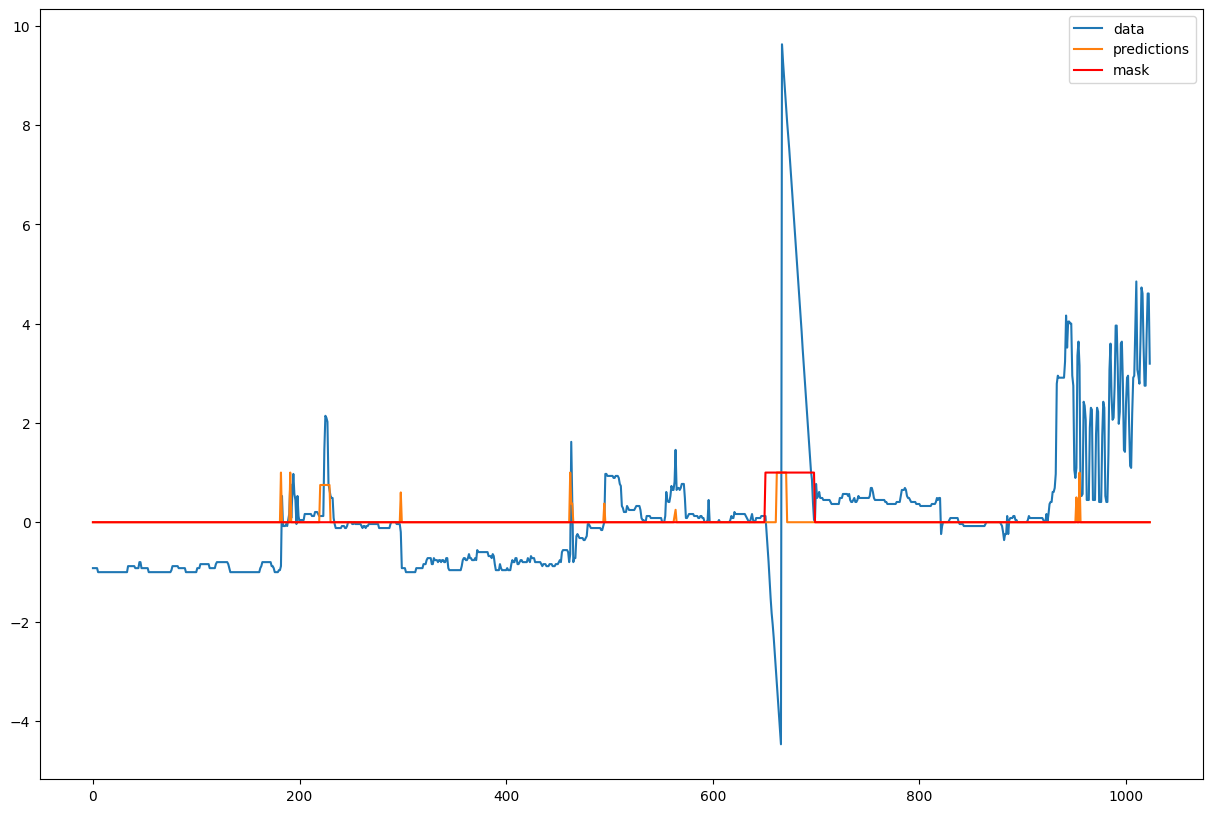

In [29]:
plt.figure(figsize=(15, 10))
plt.plot(example_data, label="data")
plt.plot(predictions, label="predictions")
plt.plot(example["mask"], c="red", label="mask")
plt.legend()
plt.show()